# Exercise 3
---

## Part 1: Low-dimensionality reduction using PCA
1. Using STL-10 10k unlabeled dataset, build a PCA with the minimum dimensionality and best reconstruction quality
2. Plot $MSE$ vs $z-dim$. Mean squared error for the entire test set vs $z$-code dimensionality. Try the following dims: $\{32, 64, 256, 512, 1028, 2046, 4098\}$

## Part 2: Using the “optimal” $z$−dim⁡ in PCA
1. Can we fit a 10-component GMM on the unlabeled dataset $z$ code vectors from PCA?
2. Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?
3. Report the accuracy on the test dataset.
4. Can we build an STL generative model using unlabeled dataset  PCA 𝒛 code vectors and GMM? 

# Solution
---

## Part 1

In [1]:
import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from skimage.transform import resize
# import tensorflow as tf
import time

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

print(sys.version_info) 

sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


Download STL-10 dataset. Below is a script. Reference link for the dataset is commented in the succeeding cell.

In [2]:
# script from Stanford
# https://cs.stanford.edu/~acoates/stl10/
# https://github.com/mttk/STL10

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

  
download_and_extract()

In [3]:
# with open(UNLABELED_PATH, 'rb') as f:
DATA_PATH = './data/stl10_binary/train_X.bin'
LABEL_PATH = './data/stl10_binary/train_y.bin'
UNLABELED_PATH = './data/stl10_binary/unlabeled_X.bin'   

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

SAMPLES = 10000

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH
COUNT = SAMPLES * SIZE

# dataset = np.fromfile(UNLABELED_PATH, dtype='uint8')
dataset = np.fromfile(UNLABELED_PATH, dtype='uint8', count=COUNT)
images = np.reshape(dataset, (-1, 3, 96, 96 ))

test_images = np.fromfile('./data/stl10_binary/test_X.bin', dtype='uint8', count=COUNT)
test_images = np.reshape(test_images, (-1, 3, 96, 96 ))

In [4]:
# RGB PLOT

def plot_images(images, title, n_images=9):
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=20)
    side = int(np.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i, :, :,]
        image = np.transpose(image, (1, 0, 2)) # so matplotlib can plot properly
        plt.imshow(image)
        plt.axis('off')

    plt.show()

### Implement PCA Algorithm

#### Mean subtraction: 
\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} - \mu
\end{equation*}

#### Divide by standard deviation: 
\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} / \sigma
\end{equation*}

#### Formulate data matrix and covariance matrix:
\begin{equation}
\textbf{X} = [ \textbf{x}_1, ..., \textbf{x}_n ]
\end{equation}

\begin{equation}
\textbf{S} = \frac{1}{N}\textbf{XX}^T
\end{equation}

#### and perform Eigendecomposition: 
\begin{equation}
\textbf{S}=\textbf{B}\textbf{D}\textbf{B}^{-1}
\end{equation}

In [5]:
def manual_PCA(images, n_images):
  # if dim:
  #   images = resize_images(images, dim)

  images = np.float32(images)
  mu = np.mean(images)
  images -= mu

  std = np.std(images)
  images /= std

  print("Before mean: {0}, std: {1}".format(mu,std))
  mu1 = np.mean(images)
  std1 = np.std(images)
  print("After mean: {0}, std: {1}".format(mu1,std1))

  X = np.reshape(images,(-1,n_images))
  S = np.matmul(X, np.transpose(X))/n_images
  #D,B = la.eig(S,left=True,right=True)
  D,B = la.eig(S,left=True,right=False)

  print('X.shape: {0}'.format(X.shape))
  print('S.shape: {0}'.format(S.shape))
  print(B.shape)
  print(D.shape)

  return B, std, mu

### To reconstruct,

#### Projection or Low-Rank Approximation of $\textbf{X}$:

\begin{equation}
\textbf{R} = \textbf{B}_{M}\textbf{B}^{T}_{M}\textbf{X}
\end{equation}

#### then Backproject,
\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n}\sigma + \mu
\end{equation*}

In [6]:
def reconstruct_from_pca(B, M, images, std, mu):
  
  BM = B[:,:M]
  BM_BMT = np.matmul(BM,np.transpose(BM))

  X = images
  X = np.float32(np.reshape(X,(-1,X.shape[0])))
  R = np.matmul(BM_BMT,X)
  R = np.reshape(R, images.shape)
  # print(R.shape)

  R *= std
  R += mu
  R = np.clip(R, 0, 255)
  # mu1 = np.mean(R)
  # std1 = np.std(R)

  return R

The original dimensions of the dataset is $(96 \times 96 \times 3)$, but due to resource constraints, we shall downscale these images tot $(48 \times 48 \times 3)$. We shall define two functions here

In [7]:
normalize = True
if normalize:
    images = np.float32(images) / 255.
    test_images = np.float32(test_images) / 255.

# images_red = images[:,0,:,:]
# images_green = images[:,1,:,:]
# images_blue = images[:,2,:,:]

print(images.shape) # (SAMPLES, 3, 96, 96)

# test_images = images[:8000]

images = images[:,:,::2,::2]
test_images = test_images[:,:,::2,::2]

print(images.shape)
print(test_images.shape)

(10000, 3, 96, 96)
(10000, 3, 48, 48)
(8000, 3, 48, 48)


Test on following $z$-dimensions. $\{32, 64, 256, 512, 1028, 2046, 4098\}$ Since we are dealing with an RGB image, we can follow this workflow for optimal computation.

1. Separate image per channel. Essentially having 6 matrices. Three each for the unlabeled and test dataset.
2. Apply PCA algorithm per channel.
3. Save $\mu$ and $\sigma$ per channel.
4. Reconstruct **test** dataset using saved $\mu$ and $\sigma$ from fitting the unlabeled dataset earlier. Do this in a per-chanell fashion.
5. Stack the R, G, and B channels per z-dim for plotting and qualitative comparison later on.

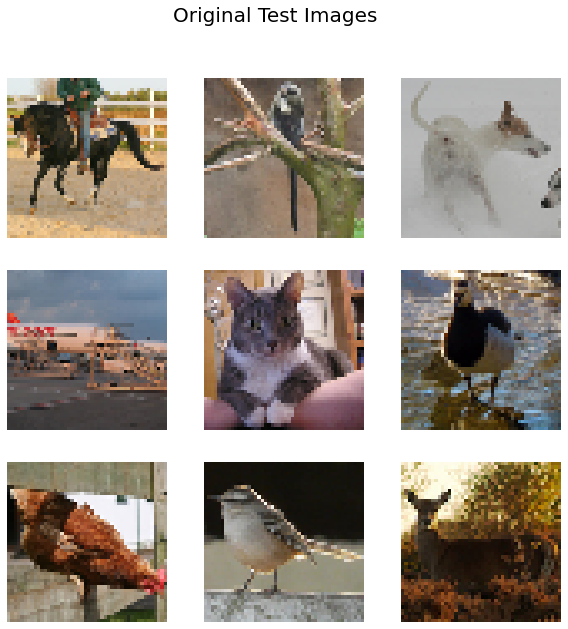

Before mean: 0.4400869309902191, std: 0.26839306950569153
After mean: -3.514464651743765e-06, std: 1.0000001192092896
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
red done
Time elapsed for Single Channel PCA :  0.09335253636042277
Before mean: 0.4289826452732086, std: 0.2613324224948883
After mean: 2.192497277064831e-06, std: 1.0000001192092896
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
green done
Before mean: 0.38924089074134827, std: 0.2692567706108093
After mean: 3.216425454866112e-07, std: 0.9999985694885254
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
blue done
PCA, DIM = 32
recon done
0.013846822579701741
Computing MSE on Test


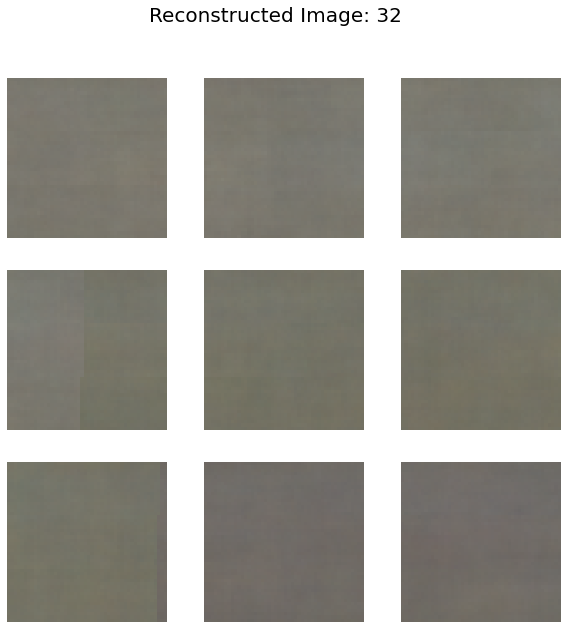

PCA, DIM = 64
recon done
0.01422580083211263
Computing MSE on Test


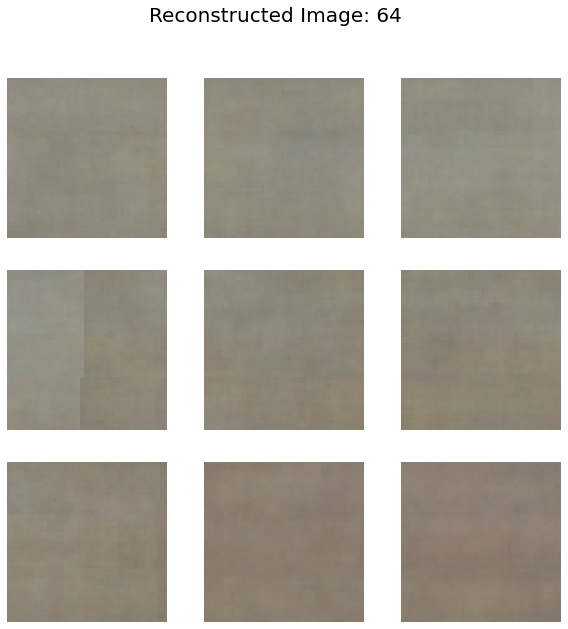

PCA, DIM = 256
recon done
0.01577002207438151
Computing MSE on Test


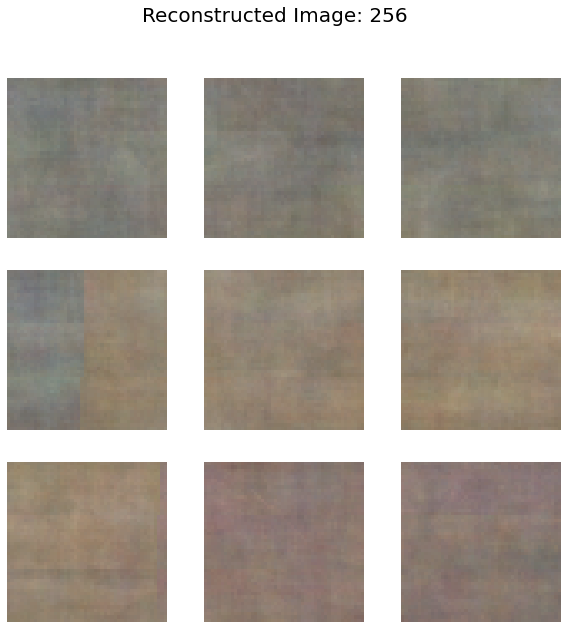

PCA, DIM = 512
recon done
0.016895592212677002
Computing MSE on Test


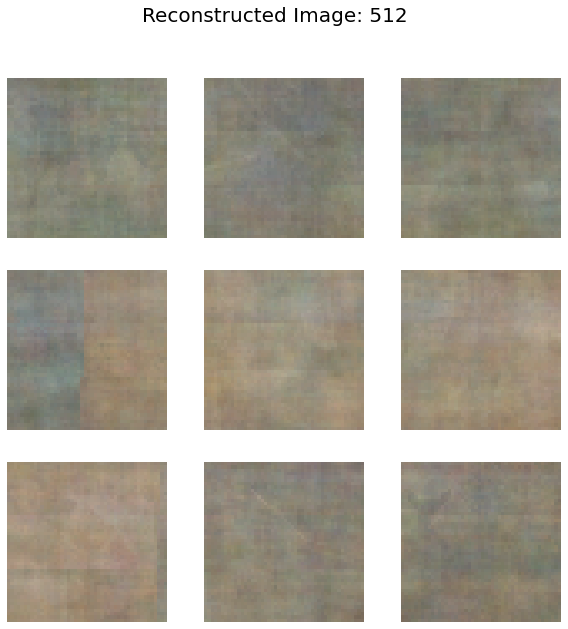

PCA, DIM = 1028
recon done
0.014875201384226482
Computing MSE on Test


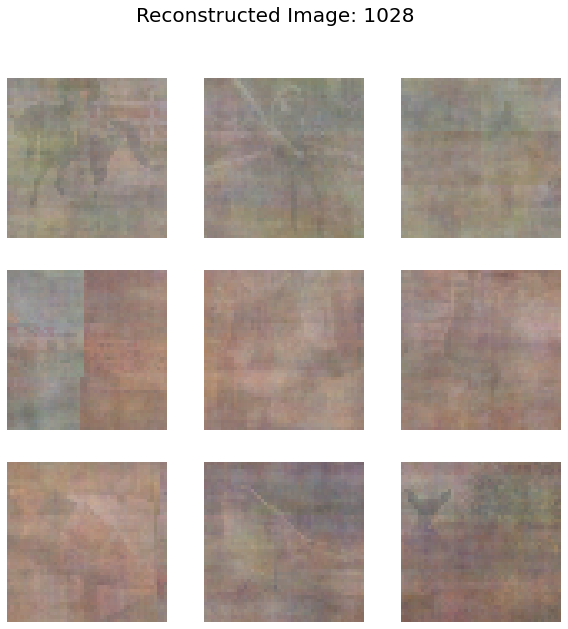

PCA, DIM = 2046
recon done
0.015546313921610514
Computing MSE on Test


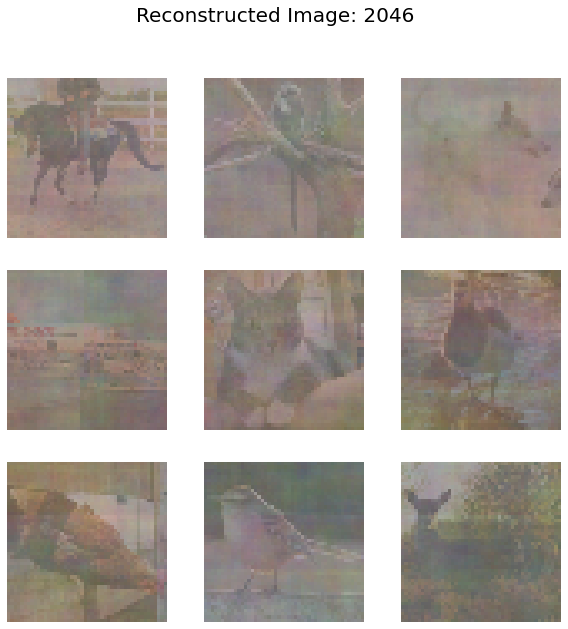

PCA, DIM = 4098
recon done
0.01677340269088745
Computing MSE on Test


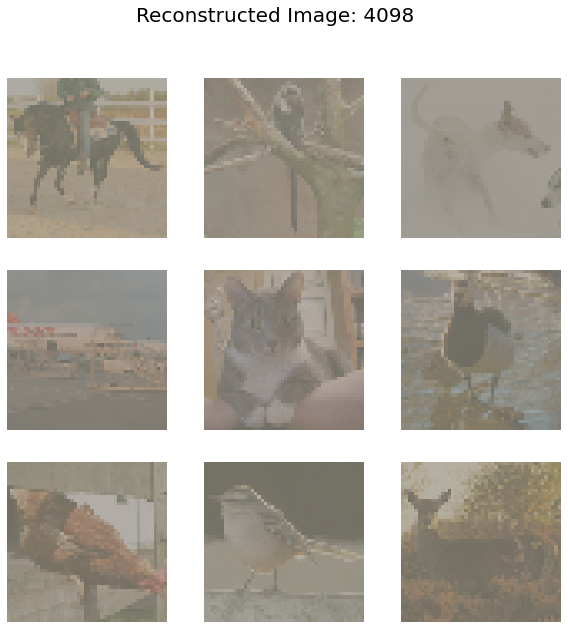

In [8]:
# dims = [32, 64, 256, 512, 1028, 2046, 4098, 5126, 6154, 7182, 8210, 9216]
dims = [32, 64, 256, 512, 1028, 2046, 4098]
# dims = [4098]

def mse_vs_dim(dims, images, samples, test_images=test_images):
  mse_per_dim = []
  comparison_images = []
  comparison_images_train = []
  DIM = 48

  test_images_red = test_images[:,0,:,:]
  test_images_green = test_images[:,1,:,:]
  test_images_blue = test_images[:,2,:,:]

  rgb_test = np.zeros((8000,DIM,DIM,3), 'float32')

  rgb_test[...,0] = test_images_red
  rgb_test[...,1] = test_images_green
  rgb_test[...,2] = test_images_blue

  images_red = images.copy()[:,0,:,:]
  images_green = images.copy()[:,1,:,:]
  images_blue = images.copy()[:,2,:,:]

  # rgb_orig = np.zeros((samples,DIM,DIM,3), 'float32')
  # rgb_orig[...,0] = images_red
  # rgb_orig[...,1] = images_green
  # rgb_orig[...,2] = images_blue 

  title = "Original Test Images"
  plot_images(rgb_test, title=title)

  start = time.time()
  r_pca, std_r, mu_r = manual_PCA(images_red, n_images=samples)
  end = time.time()
  print('red done')
  print('Time elapsed for Single Channel PCA : ', (end - start)/60)
  g_pca, std_g, mu_g = manual_PCA(images_green, n_images=samples)
  print('green done')
  b_pca, std_b, mu_b = manual_PCA(images_blue, n_images=samples)
  print('blue done')

  for i in dims:
    print('PCA, DIM =', i)
    start = time.time()

    r = reconstruct_from_pca(r_pca, i, test_images_red, std_r, mu_r)
    g = reconstruct_from_pca(g_pca, i, test_images_green, std_g, mu_g)
    b = reconstruct_from_pca(b_pca, i, test_images_blue, std_b, mu_b)

    rgb_recon = np.zeros((8000,DIM,DIM,3), 'float32')
    rgb_recon[...,0] = r
    rgb_recon[...,1] = g
    rgb_recon[...,2] = b

    end = time.time()
    print('recon done')
    print((end - start)/60)

    print('Computing MSE on Test')
    mse = np.float32(np.square(np.subtract(rgb_test, rgb_recon)).mean())
    mse_per_dim = np.append(mse_per_dim, mse)

    title = "Reconstructed Image: " + str(i) 
    plot_images(rgb_recon, title=title)
    comparison_images = np.append(comparison_images, rgb_recon[4])

    r = reconstruct_from_pca(r_pca, i, images_red, std_r, mu_r)
    g = reconstruct_from_pca(g_pca, i, images_green, std_g, mu_g)
    b = reconstruct_from_pca(b_pca, i, images_blue, std_b, mu_b)
    rgb_recon = np.zeros((10000,DIM,DIM,3), 'float32')
    rgb_recon[...,0] = r
    rgb_recon[...,1] = g
    rgb_recon[...,2] = b
    comparison_images_train = np.append(comparison_images_train, rgb_recon[0])


  return mse_per_dim, comparison_images, comparison_images_train

mse_per_dim, comparison_images, comparison_images_train = mse_vs_dim(dims=dims, images=images, samples=SAMPLES, test_images=test_images)

We then plot MSE vs $z$ dim on PCA applied on test images.

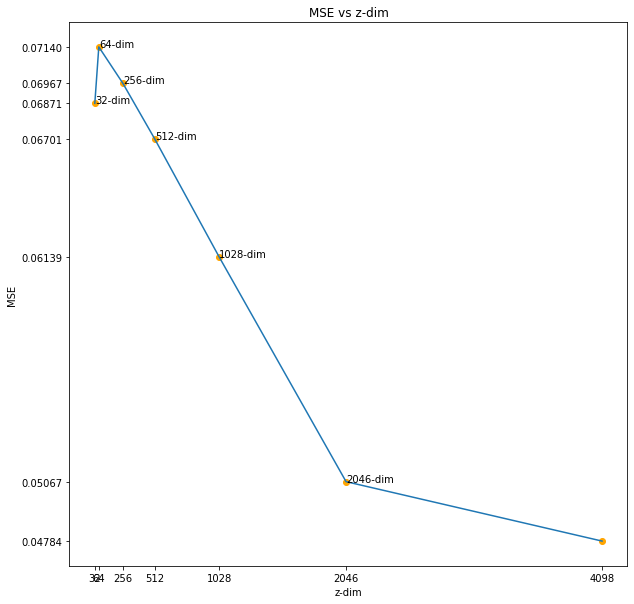

In [9]:
fig, ax = plt.subplots()
for i, txt in enumerate(dims[:6]):
    ax.annotate('%d-dim' % txt , (dims[i], mse_per_dim[i]))

fig.set_size_inches(10,10)
plt.plot(dims, mse_per_dim)
plt.scatter(dims, mse_per_dim, color='orange')
ax.set_xticks(dims)
ax.set_yticks(mse_per_dim)
plt.title('MSE vs z-dim')
plt.xlabel('z-dim')
plt.ylabel('MSE')
plt.show()

For qualitative comparison, we plot the images per $z$ dimension.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


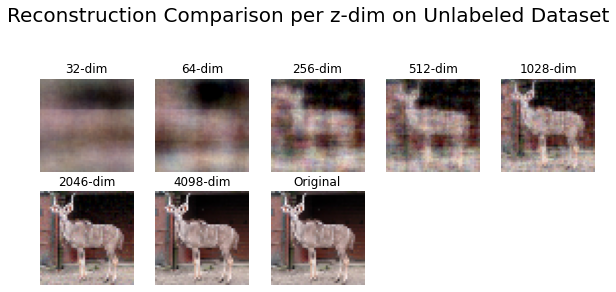

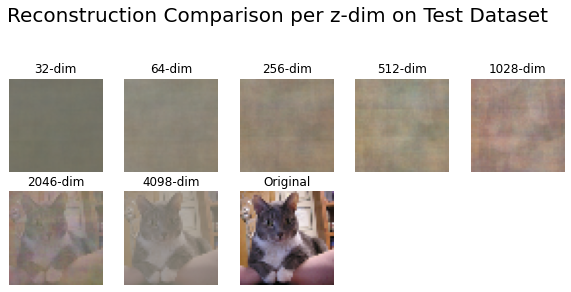

In [10]:
comparison_images_train = np.reshape(comparison_images_train,(-1,48,48,3))
comparison_images_train = np.append(comparison_images_train,np.transpose(images[0],(1,2,0)))

comparison_images_train = comparison_images_train.reshape(-1,48,48,3)

plt.figure(figsize=(10,10))
plt.suptitle('Reconstruction Comparison per z-dim on Unlabeled Dataset', fontsize=20)
side = 5
for i in range(8):
    plt.subplot(side, side, i + 1)
    image = comparison_images_train[i, :, :,]
    image = np.transpose(image, (1, 0, 2)) # so matplotlib can plot properly
    if(i==7):
        plt.title('Original')
    else:
        plt.title('%d-dim' % dims[i])
    plt.imshow(image)
    plt.axis('off')

plt.show()

comparison_images = np.reshape(comparison_images,(-1,48,48,3))
comparison_images = np.append(comparison_images,np.transpose(test_images[4],(1,2,0)))

comparison_images = comparison_images.reshape(-1,48,48,3)

plt.figure(figsize=(10,10))
plt.suptitle('Reconstruction Comparison per z-dim on Test Dataset', fontsize=20)
side = 5
for i in range(8):
    plt.subplot(side, side, i + 1)
    image = comparison_images[i, :, :,]
    image = np.transpose(image, (1, 0, 2)) # so matplotlib can plot properly
    if(i==7):
        plt.title('Original')
    else:
        plt.title('%d-dim' % dims[i])
    plt.imshow(image)
    plt.axis('off')

plt.show()


## Part 2